In [7]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [8]:
# Raw data from twitter reddit and from around the web
raw_data = pd.read_csv('huge_dataset.csv')

# Pre-trained Embeddings
EMBEDDING_FILE = f'glove.6B.100d.txt'

raw_data = raw_data_subset
raw_data.head(-10)
# 120K rows

,Unnamed: 0,Text,Emotion
2,2,Man I love reddit.,love
6,6,That's crazy; I went to a super [RELIGION] hig...,happy
7,7,that's adorable asf,happy
9,9,"I have, and now that you mention it, I think t...",neutral
10,10,"I wanted to downvote this, but it's not your f...",sadness
...,...,...,...
269249,269249,Please do n't let the dismay of the pro-Ford l...,fear
269250,269250,"There was dismay on her face , n",fear
269252,269252,I watched with dismay as they hit the floor an...,fear
269253,269253,"In this he resembled Bonamy Dobre at Leeds , w...",fear


C:\ProgramData\Anaconda3\envs\Dsci\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Emotion', ylabel='count'>

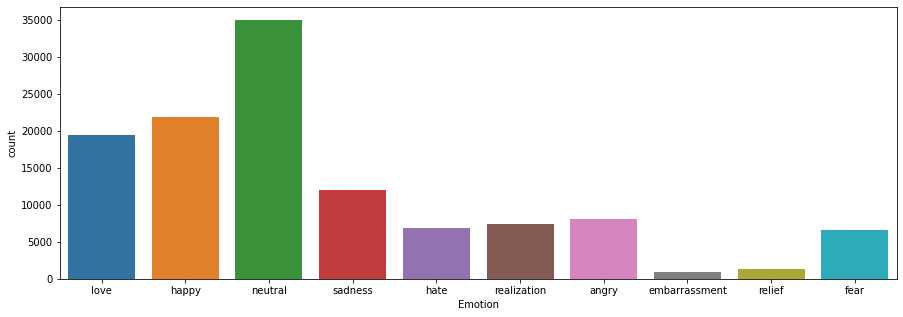

In [3]:
# Target Classes (Labels)
plt.figure(figsize=(15,5))

sns.countplot(raw_data['Emotion'])

In [4]:
# Drop columns with NA values
raw_data = raw_data.dropna() 

X = raw_data.drop('Emotion', axis=1) #input
y = raw_data['Emotion'] #output

messages = X.copy()
# Reset index after droping null columns
messages.reset_index(inplace=True)

In [5]:
nltk.download('stopwords')
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elusive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Preparing the corpus (cleaning the data)
corpus = []
for i in tqdm(range(0, len(messages))):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i]) #Remove Special Characters
    review = review.lower() #Lower case 
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] #Remove stopwords
    review = ' '.join(review)
    corpus.append(review)

 41%|████      | 48829/119273 [01:38<02:22, 493.98it/s]


KeyboardInterrupt: 

In [37]:
# Saving Progress
if len(corpus) > 100000:
    corpus_df = pd.DataFrame({'Text': corpus})
    corpus_df.to_csv('large_corpus.csv')
print(len(corpus))
corpus[-10:]

119273


['effortlessli knee slid part leg threw look utter dismay pau',
 'commerci ethic meant deterior standard cutback oversea news depart one glori bush hous caus much dismay public commun wor',
 'floyd patterson express dismay current treatm',
 'edouard look felt sicken dism',
 'tina children move school cecilia felt dismay guilti reli',
 'stare one anoth dismay sad small wicked friend neighbour strewn around mind like dirti confetti parti long pa',
 'melissa stare friend dism',
 'success state elect seen govern parti pummel dismay electora',
 'vincent irrit dismay',
 'kendal hume turn back face dismay coup']

In [59]:
# Loading Progress
temp = pd.read_csv('large_corpus.csv')
temp['Emotion'] = raw_data['Emotion'].values
temp['Text'] = temp['Text'].str.replace('\d+', '')
temp = temp.dropna()

<ipython-input-59-c58f8ac8890e>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  temp['Text'] = temp['Text'].str.replace('\d+', '')


In [7]:
temp_list = temp['Text'].tolist()
print(len(temp_list))
print(temp.shape)
temp_list[-10:]

119026
(119026, 3)


['effortlessli knee slid part leg threw look utter dismay pau',
 'commerci ethic meant deterior standard cutback oversea news depart one glori bush hous caus much dismay public commun wor',
 'floyd patterson express dismay current treatm',
 'edouard look felt sicken dism',
 'tina children move school cecilia felt dismay guilti reli',
 'stare one anoth dismay sad small wicked friend neighbour strewn around mind like dirti confetti parti long pa',
 'melissa stare friend dism',
 'success state elect seen govern parti pummel dismay electora',
 'vincent irrit dismay',
 'kendal hume turn back face dismay coup']

In [8]:
X = temp.drop('Emotion', axis=1) #input
y = temp['Emotion'] #output

In [9]:
corpus = []
corpus = temp_list
print(len(corpus))
corpus[-10:]

119026


['effortlessli knee slid part leg threw look utter dismay pau',
 'commerci ethic meant deterior standard cutback oversea news depart one glori bush hous caus much dismay public commun wor',
 'floyd patterson express dismay current treatm',
 'edouard look felt sicken dism',
 'tina children move school cecilia felt dismay guilti reli',
 'stare one anoth dismay sad small wicked friend neighbour strewn around mind like dirti confetti parti long pa',
 'melissa stare friend dism',
 'success state elect seen govern parti pummel dismay electora',
 'vincent irrit dismay',
 'kendal hume turn back face dismay coup']

In [10]:
# Creating the dictionary with word as key and pretrained-value array as value
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))


# Calculate MEAN and Standard-Deviation for the pre-trained weights
all_embeddings = np.stack(embeddings_index.values())
embedding_mean, embedding_std = all_embeddings.mean(), all_embeddings.std()
print(embedding_mean, embedding_std)

C:\ProgramData\Anaconda3\envs\Dsci\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
0.004451992 0.4081574


In [11]:
vocabulary_size = 20000
# Word vector size
embed_size = 100 

tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(list(corpus))

In [12]:
word_index = tokenizer.word_index #Total words in the corpus
nb_words = min(vocabulary_size, len(word_index))

In [13]:
# Initialize weight matrix for embedding layer
embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_words, embed_size)) 

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue #skip the words if vocab size is reached
    embedding_vector = embeddings_index.get(word) #extracting the pre-trained values from GloVe
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [14]:
# Contains the pretrained GloVe weights for the words
len(embedding_matrix)

20000

In [15]:
# One hot representation for input
onehot_repr = [one_hot(words, vocabulary_size) for words in corpus]

# Finding max words
l = 0
for x in tqdm(corpus):
    l = max(l, len(x.split(' ')))

#Padding the sequences for input
sentence_length = l
embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sentence_length)
print(embedded_docs)

100%|██████████| 119026/119026 [00:00<00:00, 1405204.53it/s]
[[    0     0     0 ...  5849  2707  1935]
 [    0     0     0 ...  5132 11561 18875]
 [    0     0     0 ...     0 13700  6801]
 ...
 [    0     0     0 ... 17127 12572  6354]
 [    0     0     0 ...  9457 14198 12572]
 [    0     0     0 ...  7458 12572  8676]]


In [16]:
# Encoding the target outputs to integers
label_encoder = preprocessing.LabelEncoder()

X_final = np.array(embedded_docs) #input to array
y = label_encoder.fit_transform(y)
y_final = np.array(y)
print(y_final)

X_final.shape, y_final.shape

[5 3 3 ... 2 2 2]


((119026, 35), (119026,))

In [17]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.2, random_state = 42)

# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 21)

In [18]:
# Creating model
model = Sequential()
model.add(Embedding(vocabulary_size, embed_size, weights=[embedding_matrix]))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(64, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(0.01))) # L1 regularization
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

In [19]:
model_save = ModelCheckpoint('large_weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss', mode = 'min', verbose = 1)

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 50, batch_size = 64, callbacks = [model_save])

Epoch 1/50
1191/1191 [==============================] - 32s 25ms/step - loss: 2.4187 - accuracy: 0.2902 - val_loss: 1.9572 - val_accuracy: 0.3418

Epoch 00001: val_loss improved from inf to 1.95723, saving model to weights.h5
Epoch 2/50
1191/1191 [==============================] - 28s 23ms/step - loss: 1.9251 - accuracy: 0.3596 - val_loss: 1.8839 - val_accuracy: 0.3770

Epoch 00002: val_loss improved from 1.95723 to 1.88387, saving model to weights.h5
Epoch 3/50
1191/1191 [==============================] - 28s 24ms/step - loss: 1.8850 - accuracy: 0.3736 - val_loss: 1.8701 - val_accuracy: 0.3769

Epoch 00003: val_loss improved from 1.88387 to 1.87011, saving model to weights.h5
Epoch 4/50
1191/1191 [==============================] - 29s 24ms/step - loss: 1.8595 - accuracy: 0.3785 - val_loss: 1.8515 - val_accuracy: 0.3791

Epoch 00004: val_loss improved from 1.87011 to 1.85152, saving model to weights.h5
Epoch 5/50
1191/1191 [==============================] - 29s 24ms/step - loss: 1.8107

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


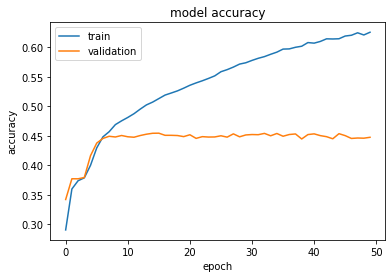

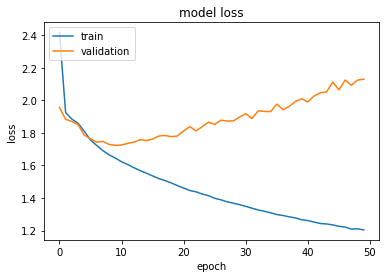

In [20]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
#Load the best weights
model.load_weights('large_weights.h5')

In [22]:
y_pred = model.predict_classes(X_test)
print(y_pred)

C:\ProgramData\Anaconda3\envs\Dsci\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
[6 3 6 ... 6 6 6]


In [23]:
# Accuracy score
print(accuracy_score(y_test,y_pred))

0.45324708056792407


In [24]:
# Classification report
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000      1573
           1    0.00000   0.00000   0.00000       184
           2    0.00000   0.00000   0.00000      1231
           3    0.57489   0.58943   0.58207      4428
           4    0.00000   0.00000   0.00000      1314
           5    0.56175   0.29990   0.39104      3928
           6    0.40308   0.82636   0.54185      7003
           7    0.00000   0.00000   0.00000      1459
           8    0.00000   0.00000   0.00000       268
           9    0.43208   0.50248   0.46463      2418

    accuracy                        0.45325     23806
   macro avg    0.19718   0.22182   0.19796     23806
weighted avg    0.36208   0.45325   0.37938     23806

C:\ProgramData\Anaconda3\envs\Dsci\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)


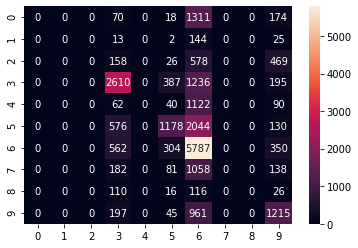

In [25]:
#Confusion Matrix
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = "d"))

In [30]:
#Mapping of target classes using label-encoder
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

emotional_class_mapping = []
for item in le_name_mapping.items():
    # print(key)
    emotional_class_mapping.append(item[0])

print(emotional_class_mapping)

{'angry': 0, 'embarrassment': 1, 'fear': 2, 'happy': 3, 'hate': 4, 'love': 5, 'neutral': 6, 'realization': 7, 'relief': 8, 'sadness': 9}
['angry', 'embarrassment', 'fear', 'happy', 'hate', 'love', 'neutral', 'realization', 'relief', 'sadness']


In [37]:
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    onehot_repr = [one_hot(review, vocabulary_size)] 
    embed = pad_sequences(onehot_repr,padding='pre',maxlen=sentence_length)
    predicti = model.predict(embed)
    return emotional_class_mapping[np.argmax(predicti)]

In [38]:
predict_emotion('I am very happy and joyful today')

'happy'

In [39]:
predict_emotion('He is an arrogant and rude person')

'neutral'

In [55]:
predict_emotion('I feel depressed')

'sadness'